In [1]:
#RUN FIRST

curr_dir = f'/user_data/csimmon2/git_repos/ptoc'

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import ptoc_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

#load additional libraries
from nilearn import image, plotting, input_data, glm
from nilearn.input_data import NiftiMasker
import nibabel as nib
import statsmodels.api as sm
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template
from nilearn.glm.first_level import compute_regressor 

suf = params.suf
#mni = load_mni152_brain_mask()

In [ ]:
'''exp info'''
#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()

study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
exp = ''
#control_tasks = ['loc']
file_suf = ''

data_dir = params.data_dir
fig_dir = params.fig_dir
task_info = params.task_info
raw_dir = params.raw_dir

'''scan params'''
tr = 1 #toolloc_params
vols = 341 #toolloc_params

whole_brain_mask = load_mni152_brain_mask()
mni = load_mni152_template()
brain_masker = NiftiMasker(whole_brain_mask, smoothing_fwhm=0, standardize=True)

/tmp/ipykernel_4687/622993337.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


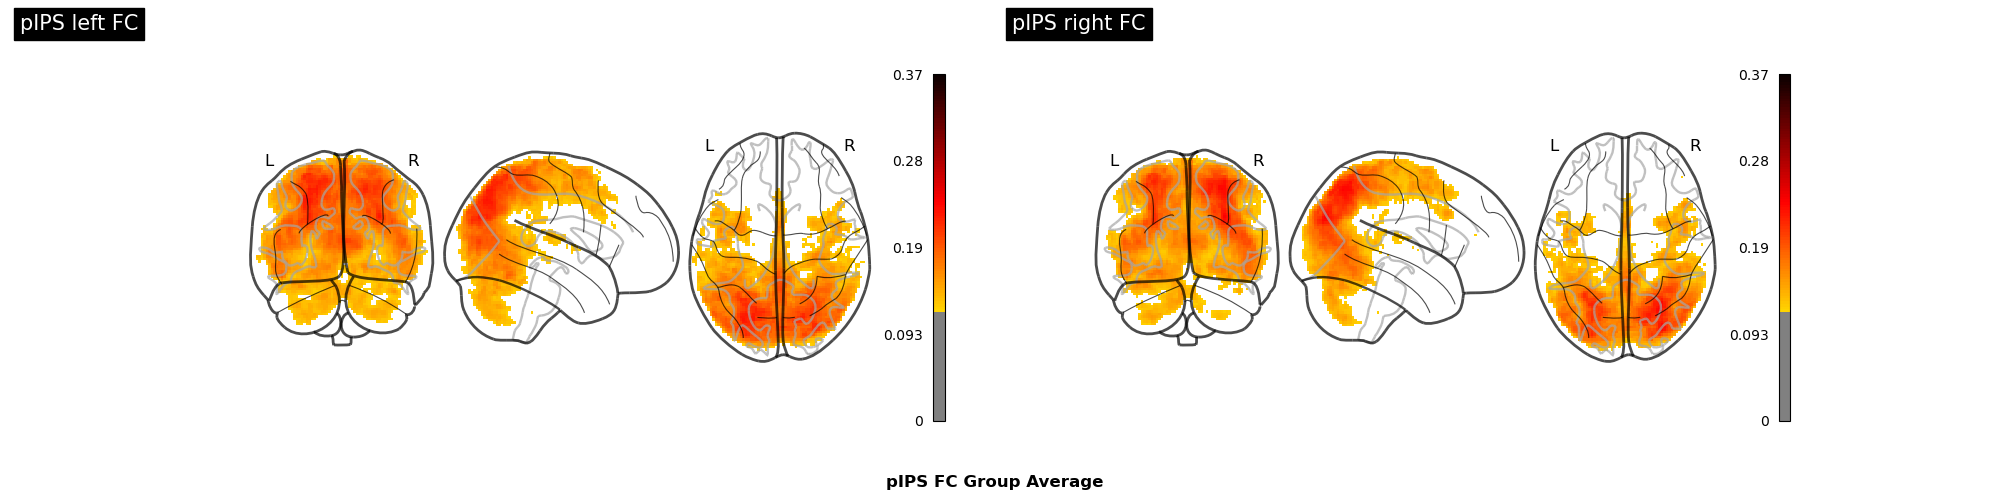

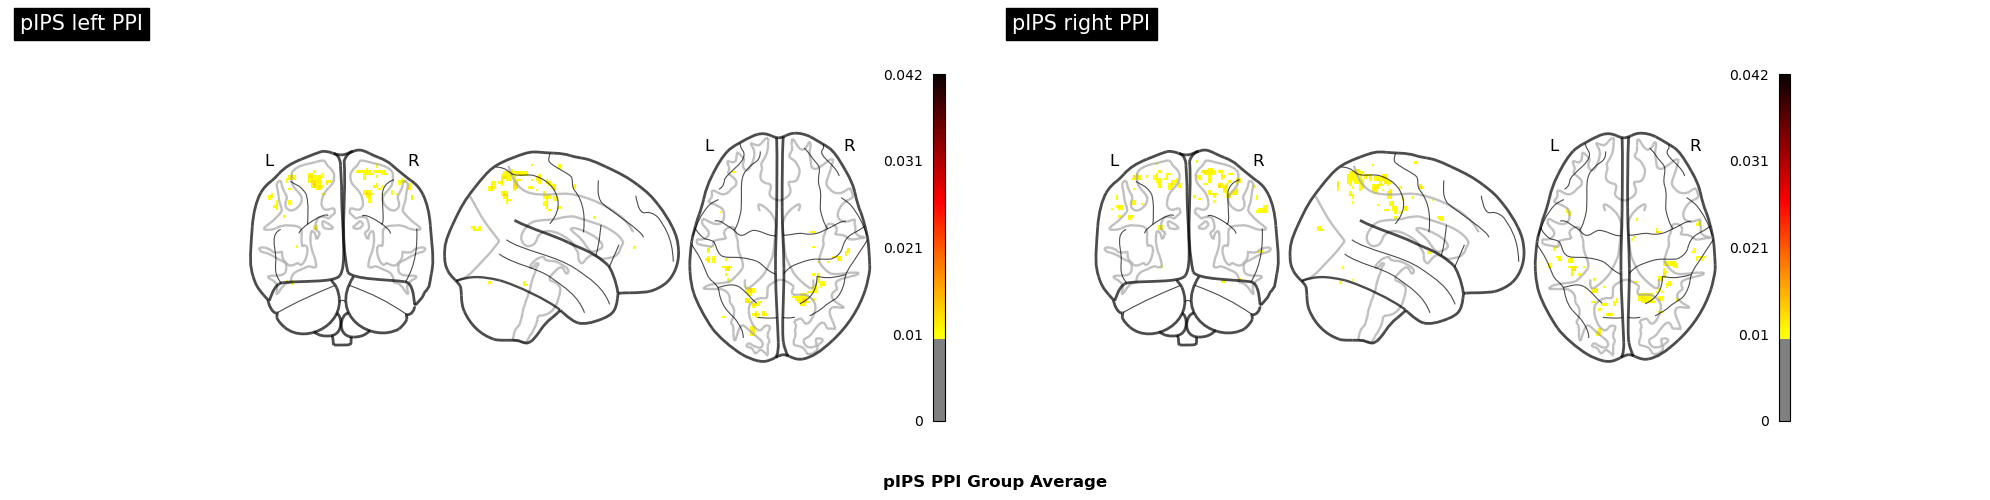

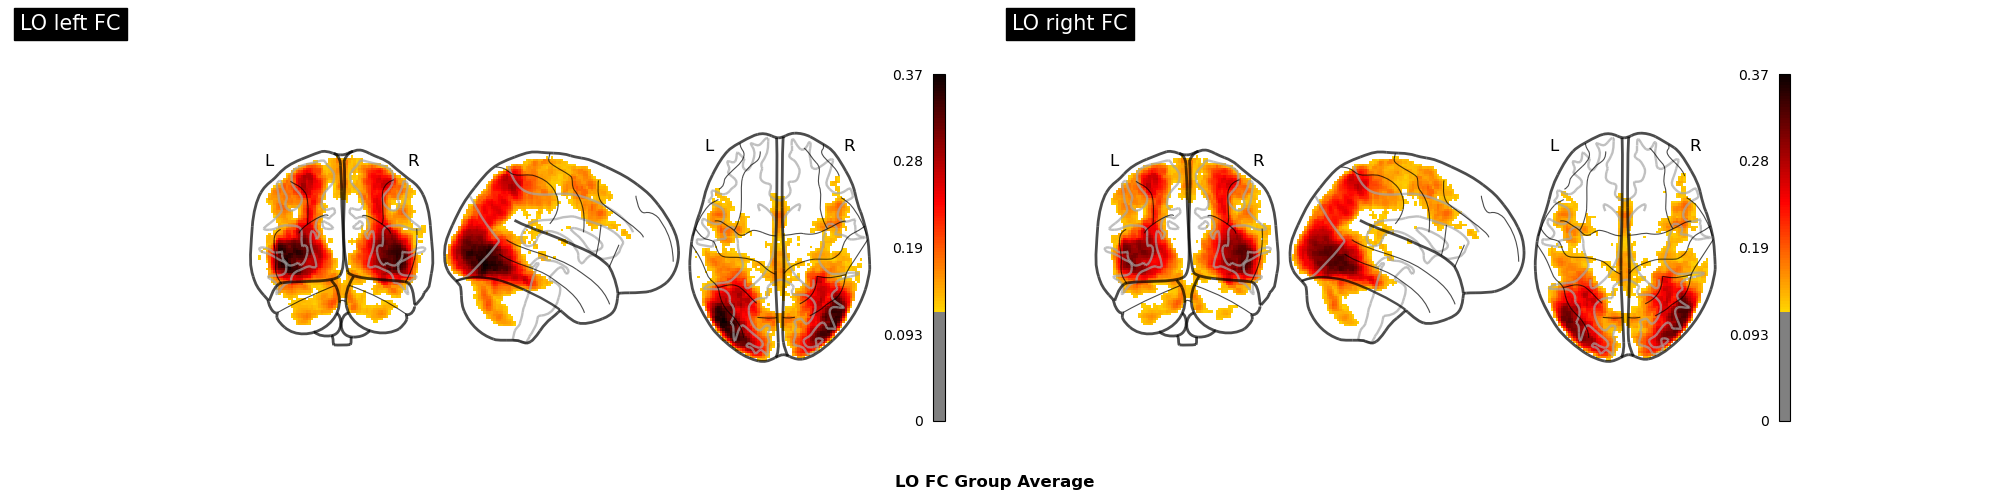

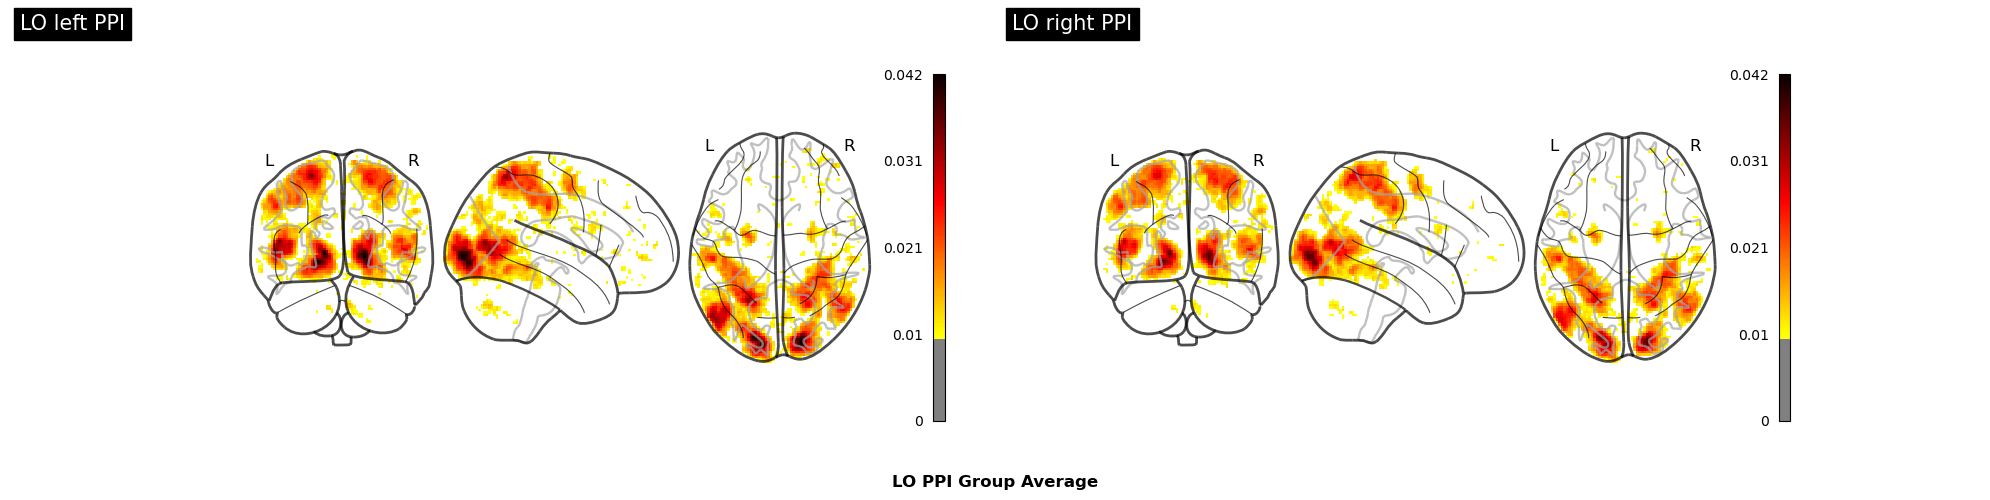

In [1]:
##group average with hemisphere object

import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study = 'ToolLoc'
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'


# Explicitly set the path to sub_info.csv
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'  # Adjust this path as needed

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']

def create_group_averages(subs, rois, hemispheres, out_dir):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['fc', 'ppi']:
                all_sub_imgs = []
                for sub in subs:
                    sub_dir = f"{study_dir}/{sub}/ses-01"
                    out_dir = f"{sub_dir}/derivatives"
                    anat_brain = f"{raw_dir}/{sub}/ses-01/anat/{sub}_ses-01_T1w_brain.nii.gz"
                    img_file = f'{out_dir}/fc/{sub}_{roi}_{hemi}_toolloc_{analysis_type}_mni.nii.gz'
                    if os.path.exists(img_file):
                        all_sub_imgs.append(image.load_img(img_file))
                    else:
                        print(f"Warning: File not found for {sub}, {roi}, {hemi}, {analysis_type}")
                
                if all_sub_imgs:
                    avg_img = image.mean_img(all_sub_imgs)
                    out_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                    nib.save(avg_img, out_file)
                    print(f"Saved group average for {roi} {hemi} {analysis_type}")
                else:
                    print(f"No images found for {roi} {hemi} {analysis_type}")

def plot_group_averages(out_dir, rois, hemispheres):
    # Calculate separate max values for FC and PPI
    fc_max = 0
    ppi_max = 0
    
    for roi in rois:
        for hemi in hemispheres:
            # Get FC max
            img_file = f'{out_dir}/{roi}_{hemi}_fc_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                fc_max = max(fc_max, np.abs(data).max())
            
            # Get PPI max
            img_file = f'{out_dir}/{roi}_{hemi}_ppi_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                ppi_max = max(ppi_max, np.abs(data).max())

    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Set max value and threshold based on analysis type
            if analysis_type == 'fc':
                vmax = fc_max
                threshold = 0.12
            else:
                vmax = ppi_max
                threshold = 0.01
            
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=threshold,
                        colorbar=True,
                        vmax=vmax, 
                        vmin=-vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i]
                    )
            
            plt.tight_layout()
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            plt.subplots_adjust(bottom=0.15)
            plt.show()

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    #create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

In [ ]:
## group average with hemisphere object - new ROI approach albeit with only two runs
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study_dir = "/user_data/csimmon2/temp_derivatives"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/tools'  # Updated path
curr_dir = '/user_data/csimmon2/git_repos/ptoc'

# Explicitly set the path to sub_info.csv
sub_info_path = f'{curr_dir}/sub_info_tool.csv'

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
rois = ['pIPS', 'LO', 'PFS', 'aIPS']  # Updated ROIs
hemispheres = ['left', 'right']

def create_group_averages(subs, rois, hemispheres, out_dir):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['fc', 'ppi']:
                all_sub_imgs = []
                for sub in subs:
                    sub_dir = f"{study_dir}/{sub}/ses-01"
                    out_dir = f"{sub_dir}/derivatives"
                    img_file = f'{out_dir}/fc/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz'  # Updated naming
                    if os.path.exists(img_file):
                        all_sub_imgs.append(image.load_img(img_file))
                    else:
                        print(f"Warning: File not found for {sub}, {roi}, {hemi}, {analysis_type}")
                
                if all_sub_imgs:
                    avg_img = image.mean_img(all_sub_imgs)
                    out_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                    nib.save(avg_img, out_file)
                    print(f"Successfully saved group average for {roi} {hemi} {analysis_type}")
                else:
                    print(f"No images found for {roi} {hemi} {analysis_type}")

def plot_group_averages(out_dir, rois, hemispheres):
    # Calculate separate max values for FC and PPI
    fc_max = 0
    ppi_max = 0
    
    for roi in rois:
        for hemi in hemispheres:
            # Get FC max
            img_file = f'{out_dir}/{roi}_{hemi}_fc_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                fc_max = max(fc_max, np.abs(data).max())
            
            # Get PPI max
            img_file = f'{out_dir}/{roi}_{hemi}_ppi_avg.nii.gz'
            if os.path.exists(img_file):
                data = nib.load(img_file).get_fdata()
                ppi_max = max(ppi_max, np.abs(data).max())

    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Set max value and threshold based on analysis type
            if analysis_type == 'fc':
                vmax = fc_max
                threshold = 0.12
            else:
                vmax = ppi_max
                threshold = 0.01
            
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=threshold,
                        colorbar=True,
                        vmax=vmax, 
                        vmin=-vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i]
                    )
            
            plt.tight_layout()
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            plt.subplots_adjust(bottom=0.15)
            plt.show()

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

Successfully saved group average for pIPS left fc


Created plot for pIPS left ppi
Created plot for pIPS right ppi
Created plot for LO left ppi
Created plot for LO right ppi


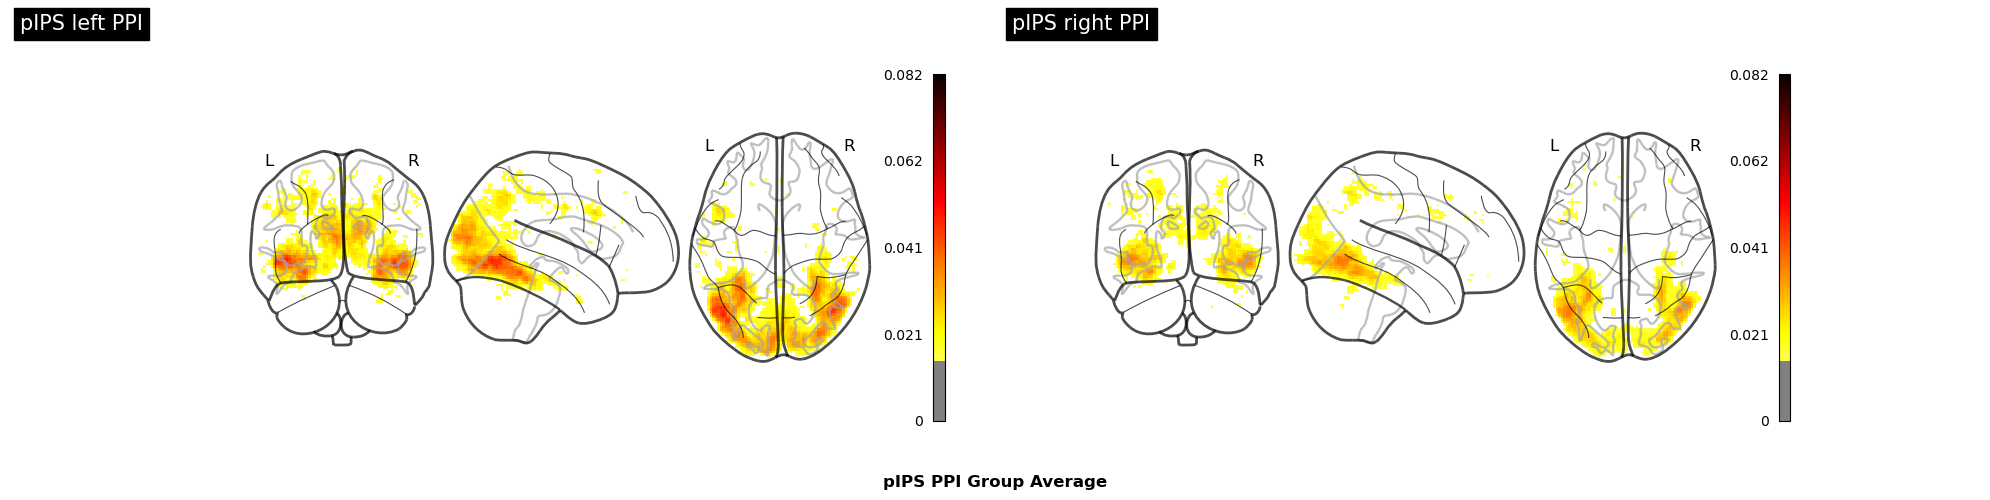

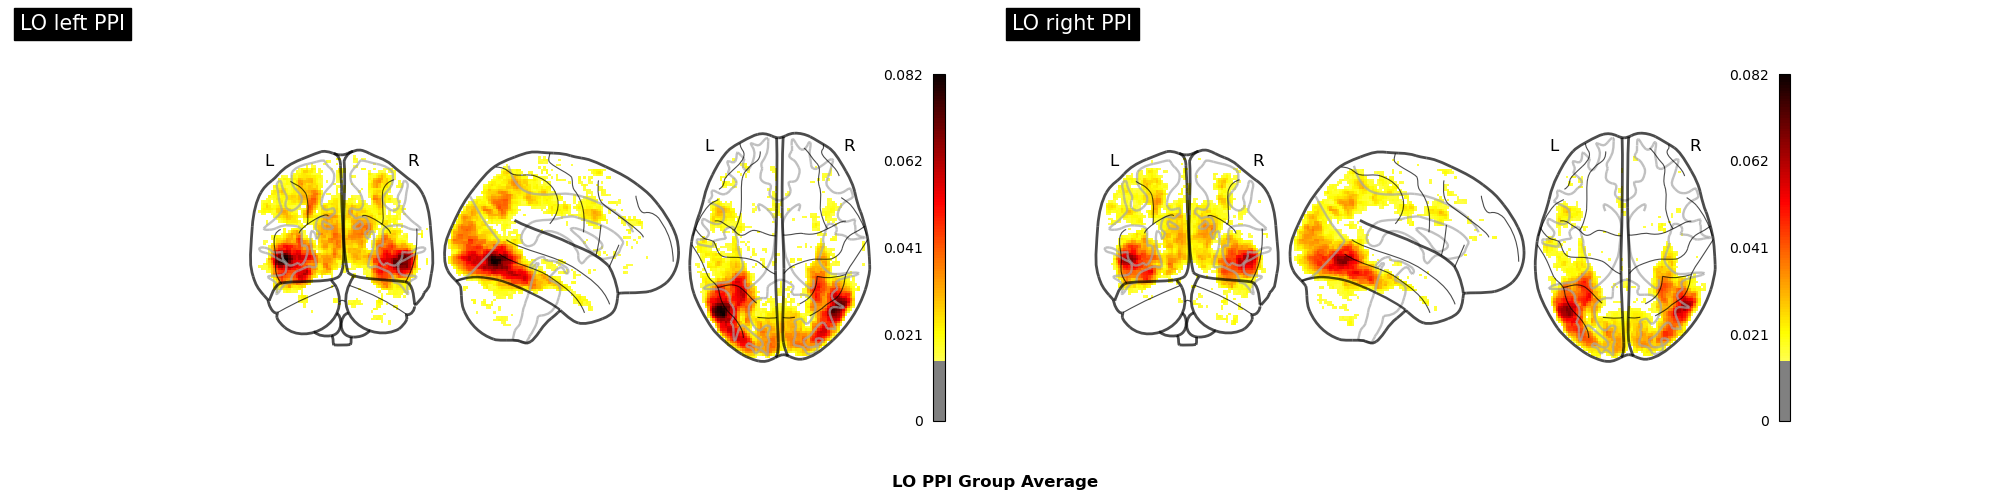

In [18]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting
import matplotlib.pyplot as plt

# Define study directories
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Explicitly set the path to sub_info.csv
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info.csv'  # Adjust this path as needed

# Define subjects and ROIs
sub_info = pd.read_csv(sub_info_path)
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
rois = ['pIPS', 'LO']
hemispheres = ['left', 'right']

def plot_group_averages(out_dir, rois, hemispheres):
    # First pass to determine global max across all ROIs
    global_vmax = 0
    for roi in rois:
        for analysis_type in ['ppi']:
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    img = nib.load(img_file)
                    data = img.get_fdata()
                    global_vmax = max(global_vmax, np.abs(data).max())

    for roi in rois:
        for analysis_type in ['ppi']:
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            
            # Plot for each hemisphere
            for i, hemi in enumerate(hemispheres):
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    display = plotting.plot_glass_brain(
                        img_file, 
                        threshold=0.015,  # Keep the original threshold for PPI
                        colorbar=True,
                        vmax=global_vmax, 
                        vmin=-global_vmax,
                        title=f'{roi} {hemi} {analysis_type.upper()}',
                        axes=axes[i]
                    )
                    print(f"Created plot for {roi} {hemi} {analysis_type}")
                else:
                    print(f"Image file not found for {roi} {hemi} {analysis_type}")
            
            plt.tight_layout()
            
            # Add title at the bottom
            fig.text(0.5, 0.01, f'{roi} {analysis_type.upper()} Group Average', 
                     ha='center', va='bottom', fontsize=12, fontweight='bold')
            
            # Adjust subplot positions to make room for the bottom title
            plt.subplots_adjust(bottom=0.15)
            
            #fig.savefig(f'{out_dir}/{roi}_{analysis_type}_group_average.png', dpi=300, bbox_inches='tight')
            #plt.close(fig)

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

Created plots for PFS left ppi
Created plots for PFS right ppi
Created plots for aIPS left ppi
Created plots for aIPS right ppi
Created plots for pIPS left ppi
Created plots for pIPS right ppi
Created plots for LO left ppi
Created plots for LO right ppi


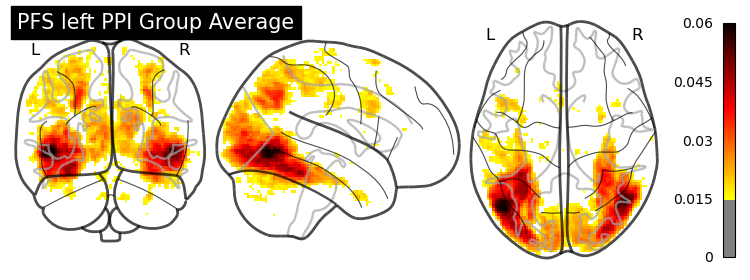

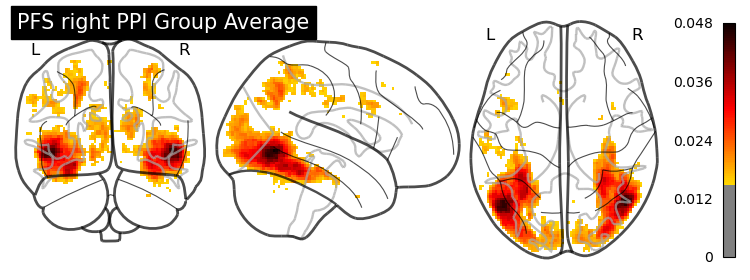

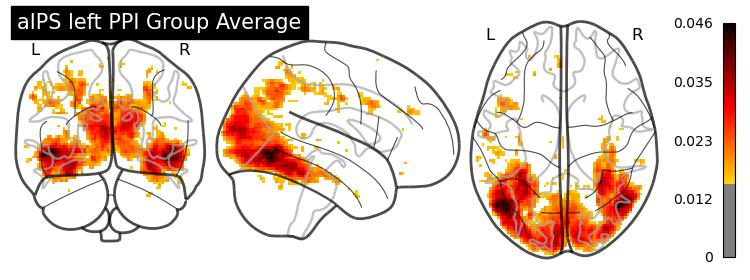

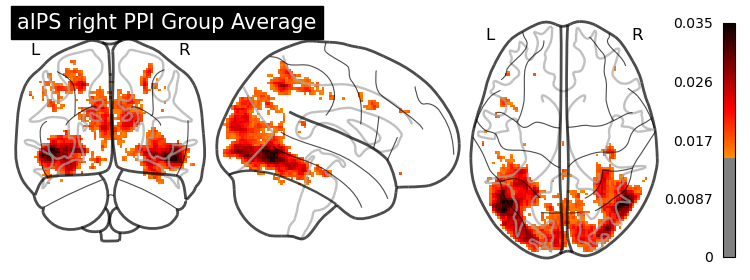

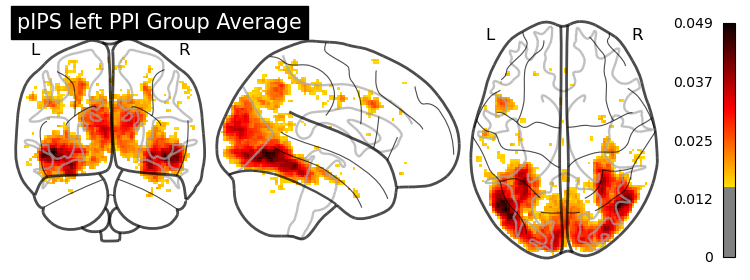

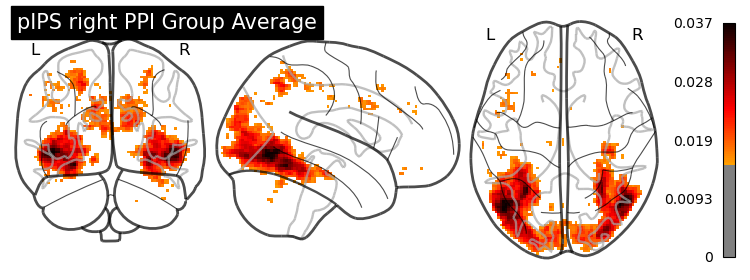

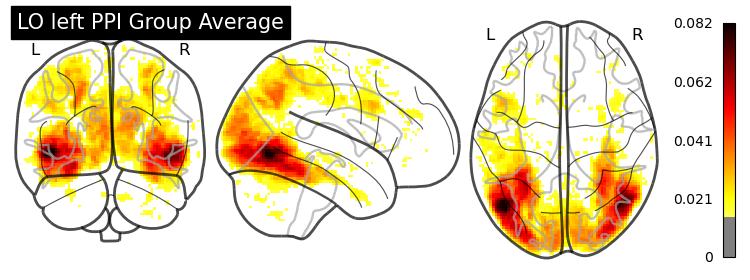

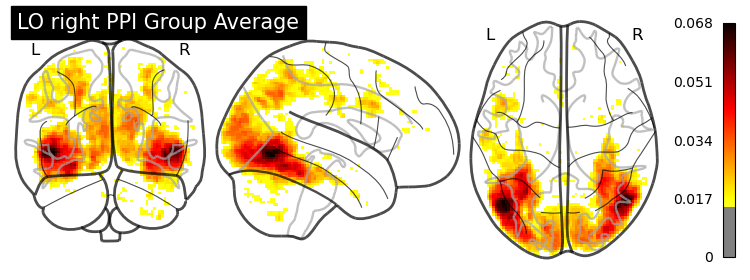

In [7]:
#plot PPI with hemispheres

import os
import numpy as np
import nibabel as nib
from nilearn import image, plotting

# Define study directories
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Define subjects and ROIs
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
#rois = ['PFS', 'aIPS', 'pIPS', 'LO']  # Add more ROIs as needed
rois = ['pIPS', 'LO']

hemispheres = ['left', 'right']


def plot_group_averages(out_dir, rois, hemispheres):
    for roi in rois:
        for hemi in hemispheres:
            for analysis_type in ['ppi']:  # ['fc', 'ppi']
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    # Plot on glass brain
                    plot = plotting.plot_glass_brain(img_file, threshold=0.015, colorbar=True,
                                                    title=f'{roi} {hemi} {analysis_type.upper()} Group Average')
                    plot.savefig(f'{out_dir}/{roi}_{hemi}_{analysis_type}_glass_brain.png')
                    
                    # Plot on MNI152 template
                    # plot = plotting.plot_stat_map(img_file, threshold=0.12, colorbar=True,
                    #                               title=f'{roi} {hemi} {analysis_type.upper()} Group Average')
                    # plot.savefig(f'{out_dir}/{roi}_{hemi}_{analysis_type}_mni152.png')
                    
                    print(f"Created plots for {roi} {hemi} {analysis_type}")
                else:
                    print(f"Image file not found for {roi} {hemi} {analysis_type}")

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)

    # Create group averages
    #create_group_averages(subs, rois, hemispheres, group_out_dir)

    # Plot group averages
    plot_group_averages(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

In [ ]:
# group average and plot fc
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Define subjects and ROIs
#subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
subs = ['sub-025', 'sub-038', 'sub-107']
rois = ['pIPS', 'LO']  # Add more ROIs as needed

def create_group_averages(subs, rois, out_dir):
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            all_sub_imgs = []
            for sub in subs:
                img_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_loc_{analysis_type}_mni.nii.gz'
                if os.path.exists(img_file):
                    all_sub_imgs.append(image.load_img(img_file))
                else:
                    print(f"Warning: File not found for {sub}, {roi}, {analysis_type}")
            
            if all_sub_imgs:
                avg_img = image.mean_img(all_sub_imgs)
                out_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
                nib.save(avg_img, out_file)
                print(f"Saved group average for {roi} {analysis_type}")
            else:
                print(f"No images found for {roi} {analysis_type}")

def plot_group_averages(out_dir, rois):
    for roi in rois:
        for analysis_type in ['fc']: #['fc', 'ppi']
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Plot on glass brain
                plot = plotting.plot_glass_brain(img_file, threshold=.1, colorbar=True, 
                                                 title=f'{roi} {analysis_type.upper()} Group Average')
                plot.savefig(f'{out_dir}/{roi}_{analysis_type}_glass_brain.png')
                
                # Plot on MNI152 template
                #plot = plotting.plot_stat_map(img_file, threshold=.12, colorbar=True, 
                                              #title=f'{roi} {analysis_type.upper()} Group Average')
                #plot.savefig(f'{out_dir}/{roi}_{analysis_type}_mni152.png')
                
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)
    
    # Create group averages
    create_group_averages(subs, rois, group_out_dir)
    
    # Plot group averages
    plot_group_averages(group_out_dir, rois)

if __name__ == "__main__":
    main()

In [ ]:
# plot ppi
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Define subjects and ROIs
#subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
subs = ['sub-025']
rois = ['pIPS', 'LO']  # Add more ROIs as needed

def create_group_averages(subs, rois, out_dir):
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            all_sub_imgs = []
            for sub in subs:
                img_file = f'{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_loc_{analysis_type}_mni.nii.gz'
                if os.path.exists(img_file):
                    all_sub_imgs.append(image.load_img(img_file))
                else:
                    print(f"Warning: File not found for {sub}, {roi}, {analysis_type}")
            
            if all_sub_imgs:
                avg_img = image.mean_img(all_sub_imgs)
                out_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
                nib.save(avg_img, out_file)
                print(f"Saved group average for {roi} {analysis_type}")
            else:
                print(f"No images found for {roi} {analysis_type}")

def plot_group_averages(out_dir, rois):
    for roi in rois:
        for analysis_type in ['ppi']: 
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Plot on glass brain
                plot = plotting.plot_glass_brain(img_file, threshold=0.05, colorbar=True, 
                                                 title=f'{roi} {analysis_type.upper()} Group Average')
                plot.savefig(f'{out_dir}/{roi}_{analysis_type}_glass_brain.png')     
                           
                print(f"Created plots for {roi} {analysis_type}")
                
                print(f"Image file not found for {roi} {analysis_type}")

                # Plot on MNI152 template
                #plot = plotting.plot_stat_map(img_file, threshold=.012, colorbar=True, 
                                              #title=f'{roi} {analysis_type.upper()} Group Average')
                #plot.savefig(f'{out_dir}/{roi}_{analysis_type}_mni152.png')
                
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)
    
    # Create group averages
    create_group_averages(subs, rois, group_out_dir)
    
    # Plot group averages
    plot_group_averages(group_out_dir, rois)

if __name__ == "__main__":
    main()

In [ ]:
#plot interactive surf
import os
import pandas as pd
import numpy as np
from nilearn import image, plotting
from nilearn.maskers import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import nibabel as nib
from IPython.display import display

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/GitHub_Repos/ptoc/results'

# Define subjects and ROIs
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
rois = ['V1', 'aIPS', 'LO']  # Add more ROIs as needed

def plot_group_averages(out_dir, rois):
    surface_plots = {}
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Interactive surface plot
                surface_plot = plotting.view_img_on_surf(img_file, threshold='90%', colorbar=True, 
                                                         title=f'{roi} {analysis_type.upper()} Group Average')
                surface_plots[f'{roi}_{analysis_type}'] = surface_plot
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")
    return surface_plots

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    #os.makedirs(group_out_dir, exist_ok=True)

    # Plot group averages and return surface plots
    surface_plots = plot_group_averages(group_out_dir, rois)
    return surface_plots

# Run the main function and get the surface plots
surface_plots = main()

# Display the surface plots
for plot_name, plot in surface_plots.items():
    #print(f"Displaying {plot_name}")
    display(plot)

In [ ]:
#plot interactive surf
import os
import pandas as pd
import numpy as np
from nilearn import image, plotting
from nilearn.maskers import NiftiMasker
from nilearn.datasets import load_mni152_brain_mask
import nibabel as nib
from IPython.display import display

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
results_dir = '/user_data/csimmon2/GitHub_Repos/ptoc/results'

# Define subjects and ROIs
subs = sub_info[sub_info['group'] == 'control']['sub'].tolist()
rois = ['pIPS', 'LO']  # Add more ROIs as needed

def plot_group_averages(out_dir, rois):
    surface_plots = {}
    for roi in rois:
        for analysis_type in ['fc', 'ppi']:
            img_file = f'{out_dir}/{roi}_{analysis_type}_avg.nii.gz'
            if os.path.exists(img_file):
                # Interactive surface plot
                surface_plot = plotting.view_img_on_surf(img_file, threshold='90%', colorbar=True, 
                                                         title=f'{roi} {analysis_type.upper()} Group Average')
                surface_plots[f'{roi}_{analysis_type}'] = surface_plot
                print(f"Created plots for {roi} {analysis_type}")
            else:
                print(f"Image file not found for {roi} {analysis_type}")
    return surface_plots

def main():
    # Create output directory for group averages
    group_out_dir = f'{results_dir}/group_averages'
    #os.makedirs(group_out_dir, exist_ok=True)

    # Plot group averages and return surface plots
    surface_plots = plot_group_averages(group_out_dir, rois)
    return surface_plots

# Run the main function and get the surface plots
surface_plots = main()

# Display the surface plots
for plot_name, plot in surface_plots.items():
    #print(f"Displaying {plot_name}")
    display(plot)